# Twin Delayed Deep Deterministic Policy Gradient (TD3)

# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from laserhockey.hockey_env import BasicOpponent, HockeyEnv_BasicOpponent
from laserhockey.TrainingHall import TrainingHall
import gym
#import roboschool
import sys
from DDPG.ddpg_agent import DDPGAgent
from DQN.agent import DQNAgent
import matplotlib.pyplot as plt

# Networks

In [2]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [3]:
class Actor(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            action output of network with tanh activation
    """
    
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action


    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x)) 
        return x



In [4]:
class Critic(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            value output of network 
    """
    
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)


    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2


    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1

# Memory

In [5]:
# Code based on: 
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

# Expects tuples of (state, next_state, action, reward, done)
class ReplayBuffer(object):
    """Buffer to store tuples of experience replay"""
    
    def __init__(self, max_size=150000):
        """
        Args:
            max_size (int): total amount of tuples to store
        """
        
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        """Add experience tuples to buffer
        
        Args:
            data (tuple): experience replay tuple
        """
        
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Samples a random amount of experiences from buffer of batch size
        
        Args:
            batch_size (int): size of sample
        """
        
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, next_states, rewards, dones = [], [], [], [], []

        for i in ind: 
            s, a, s_, r, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            next_states.append(np.array(s_, copy=False))
            rewards.append(np.array(r, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(next_states), np.array(rewards).reshape(-1, 1), np.array(dones).reshape(-1, 1)

# Agent

In [6]:
class TD3(object):
    """Agent class that handles the training of the networks and provides outputs as actions
    
        Args:
            state_dim (int): state size
            action_dim (int): action size
            max_action (float): highest action to take
            device (device): cuda or cpu to process tensors
            env (env): gym environment to use
    
    """
    
    def __init__(self, observation_space, action_space, pretrained=False):
        state_dim  = observation_space.shape[0]
        action_dim = action_space.shape[0]
        max_action = float(action_space.high[0])
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.action_space = action_space
        
        #self.scaling = torch.tensor([ 5.0,  5.0 , 5.0, 3.0, 3.0, 3.0,  
        #                                2.0,  2.0,  1.0, 1.0, 1.0, 1.0,  
        #                               10.0, 10.0, 10.0, 10.0, 5.0 ,5.0])
        if pretrained:
            self.load(pretrained)


        
    def act(self, state, eps=0.0):
        """Select an appropriate action from the agent policy
        
            Args:
                state (array): current state of environment
                eps (float): how much noise to add to acitons
                
            Returns:
                action (float): action clipped within action range
        
        """
        
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)#*self.scaling
        action = self.actor(state).cpu().data.numpy().flatten()
        if eps != 0: 
            action = (action + np.random.normal(0, eps, size=self.action_space.shape[0]))
            
        return action.clip(self.action_space.low, self.action_space.high)

    
    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        """Train and update actor and critic networks
        
            Args:
                replay_buffer (ReplayBuffer): buffer for experience replay
                iterations (int): how many times to run training
                batch_size(int): batch size to sample from replay buffer
                discount (float): discount factor
                tau (float): soft update for main networks to target networks
                
            Return:
                actor_loss (float): loss from actor network
                critic_loss (float): loss from critic network
        
        """
        
        for it in range(iterations):

            # Sample replay buffer 
            x, y, u, r, d = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(x).to(device)#*self.scaling
            action = torch.FloatTensor(u).to(device)
            next_state = torch.FloatTensor(y).to(device)#*self.scaling
            done = torch.FloatTensor(1 - d).to(device)
            reward = torch.FloatTensor(r).to(device)
            
            # #add noise to observation
            #clean_idx = (torch.tensor([ 0,1,2,3,4,5,12,13,14,15, 16, 17]),)
            #noise = torch.FloatTensor(state).data.normal_(0, 1).to(device)
            #noise[clean_idx] = 0
            #state += noise

            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(u).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q) 

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))


    def load(self, filename="best_avg", directory="TD3/saves"):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Runner

In [7]:
class Runner():
    """Carries out the environment steps and adds experiences to memory"""
    
    def __init__(self, env, agent, replay_buffer):
        
        self.env = env
        self.agent = agent
        self.replay_buffer = replay_buffer
        self.obs = env.reset()
        self.done = False
        
    def next_step(self, episode_timesteps, noise=0.1):
        
        action = self.agent.act(np.array(self.obs), eps=0.1)

        # Perform action
        new_obs, reward, done, info = self.env.step(action) 
        done_bool = 0 if episode_timesteps + 1 == 255 else float(done)
        
        #add proxy
        reward += sum(list(info.values()))
        
        # Store data in replay buffer
        replay_buffer.add((self.obs, new_obs, action, reward, done_bool))
        
        self.obs = new_obs
        
        if done:
            self.obs = self.env.reset()
            done = False
            
            return reward, True
        
        return reward, done

# Evaluate

In [8]:
def evaluate_policy(policy, env, eval_episodes=100,render=False):
    """run several episodes using the best agent policy
        
        Args:
            policy (agent): agent to evaluate
            env (env): gym environment
            eval_episodes (int): how many test episodes to run
            render (bool): show training
        
        Returns:
            avg_reward (float): average reward over the number of evaluations
    
    """
    
    avg_reward = 0.
    for i in range(eval_episodes):
        obs = env.reset()
        done = False
        while not done:
            if render:
                env.render()
            action = policy.act(np.array(obs), eps=0)
            obs, reward, done, _ = env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    print("\n---------------------------------------")
    print("Evaluation over {:d} episodes: {:f}" .format(eval_episodes, avg_reward))
    print("---------------------------------------")
    return avg_reward

# Observation

In [9]:
def observe(env,replay_buffer, observation_steps):
    """run episodes while taking random actions and filling replay_buffer
    
        Args:
            env (env): gym environment
            replay_buffer(ReplayBuffer): buffer to store experience replay
            observation_steps (int): how many steps to observe for
    
    """
    
    time_steps = 0
    obs = env.reset()
    done = False

    while time_steps < observation_steps:
        action = env.action_space.sample()
        new_obs, reward, done, _ = env.step(action)

        replay_buffer.add((obs, new_obs, action, reward, done))

        obs = new_obs
        time_steps += 1

        if done:
            obs = env.reset()
            done = False

        print("\rPopulating Buffer {}/{}.".format(time_steps, observation_steps), end="")
        sys.stdout.flush()

# Train

In [10]:
def train(agent, env):
    """Train the agent for exploration steps
    
        Args:
            agent (Agent): agent to use
            env (environment): gym environment
            writer (SummaryWriter): tensorboard writer
            exploration (int): how many training steps to run
    
    """

    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    done = False 
    evaluations = []
    rewards = []
    best_avg = -5
    
    writer = SummaryWriter(comment="-last")
    
    while total_timesteps < EXPLORATION:
    
        if done and total_timesteps != 0:

            rewards.append(episode_reward)
            avg_reward = np.mean(rewards[-100:])

            writer.add_scalar("avg_reward", avg_reward, total_timesteps)
            writer.add_scalar("reward_step", reward, total_timesteps)
            writer.add_scalar("episode_reward", episode_reward, total_timesteps)

            if best_avg < avg_reward:
                best_avg = avg_reward
                print("saving best model....\n")
                agent.save("best_avg","TD3/saves")

            print("\rTotal T: {:d} Episode Num: {:d} Reward: {:f} Avg Reward: {:f}".format(
                total_timesteps, episode_num, episode_reward, avg_reward), end="")
            sys.stdout.flush()


            if avg_reward >= REWARD_THRESH:
                break

            agent.train(replay_buffer, 
                        episode_timesteps, 
                        BATCH_SIZE, GAMMA, TAU, NOISE, NOISE_CLIP, POLICY_FREQUENCY)

            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        reward, done = runner.next_step(episode_timesteps)
        episode_reward += reward

        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1

# Config

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 5
OBSERVATION = 10000
EXPLORATION = 1000000
BATCH_SIZE = 100
GAMMA = 0.99
TAU = 0.005
NOISE = 0.2
NOISE_CLIP = 0.5
EXPLORE_NOISE = 0.2
POLICY_FREQUENCY = 2
EVAL_FREQUENCY = 5000
REWARD_THRESH = 100

In [12]:
env = TrainingHall(weak_opponent=True)

basic  = BasicOpponent(weak=False)
td3   = TD3(env.observation_space, env.action_space, pretrained='stronger')
last = TD3(env.observation_space, env.action_space, pretrained='lasttry')


env.register_opponents([basic,last])#,ddpg,q_agent])


current winratios: [0.]



# Main

In [13]:
# Set seeds
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

policy = TD3(env.observation_space, env.action_space, pretrained=False)

replay_buffer = ReplayBuffer(max_size=300000)

runner = Runner(env, policy, replay_buffer)

total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True


current winratios: [0. 0. 0.]



In [14]:
# Populate replay buffer
observe(env, replay_buffer, OBSERVATION)

Populating Buffer 10000/10000.

In [15]:
# Train agent
train(policy, env)

saving best model....

Total T: 8463 Episode Num: 46 Reward: -14.611141 Avg Reward: -9.1823365
current winratios: [-0.17142857 -0.18181818 -0.2972973 ]

Total T: 21690 Episode Num: 146 Reward: -13.847447 Avg Reward: -5.536663
current winratios: [-0.35526316 -0.203125   -0.35384615]

Total T: 34078 Episode Num: 246 Reward: -12.394910 Avg Reward: -1.169145
current winratios: [-0.33       -0.2        -0.37755102]

Total T: 49286 Episode Num: 346 Reward: -4.639728 Avg Reward: -1.4613767
current winratios: [-0.35 -0.19 -0.38]

Total T: 51535 Episode Num: 360 Reward: 26.243660 Avg Reward: -0.3114634saving best model....

Total T: 52498 Episode Num: 368 Reward: 2.115364 Avg Reward: 0.034315715saving best model....

Total T: 52607 Episode Num: 369 Reward: -11.227525 Avg Reward: 0.148258saving best model....

Total T: 52667 Episode Num: 370 Reward: 24.647559 Avg Reward: 0.319834saving best model....

Total T: 52729 Episode Num: 371 Reward: 23.717215 Avg Reward: 0.680437saving best model....

To

Total T: 253345 Episode Num: 1709 Reward: 32.222773 Avg Reward: 10.7138620saving best model....

Total T: 253475 Episode Num: 1710 Reward: 27.373192 Avg Reward: 10.794004saving best model....

Total T: 253726 Episode Num: 1711 Reward: 13.325014 Avg Reward: 11.030942saving best model....

Total T: 253977 Episode Num: 1712 Reward: 13.523734 Avg Reward: 11.265407saving best model....

Total T: 254479 Episode Num: 1714 Reward: 0.000000 Avg Reward: 11.461573saving best model....

Total T: 254665 Episode Num: 1716 Reward: -7.581369 Avg Reward: 11.300492saving best model....

Total T: 254695 Episode Num: 1717 Reward: 26.436310 Avg Reward: 11.648720saving best model....

Total T: 254868 Episode Num: 1718 Reward: 34.569861 Avg Reward: 12.072920saving best model....

Total T: 255237 Episode Num: 1722 Reward: 21.067344 Avg Reward: 12.125865saving best model....

Total T: 255514 Episode Num: 1724 Reward: 2.799163 Avg Reward: 12.0997861saving best model....

Total T: 255559 Episode Num: 1725 Reward

Total T: 581239 Episode Num: 3831 Reward: 30.447808 Avg Reward: 18.803650saving best model....

Total T: 581490 Episode Num: 3832 Reward: 18.137004 Avg Reward: 18.927553saving best model....

Total T: 581602 Episode Num: 3833 Reward: 29.360314 Avg Reward: 18.965950saving best model....

Total T: 582758 Episode Num: 3840 Reward: -11.966270 Avg Reward: 19.155137saving best model....

Total T: 583715 Episode Num: 3846 Reward: 2.879212 Avg Reward: 18.99795248
current winratios: [0.29 0.18 0.61]

Total T: 584050 Episode Num: 3849 Reward: 24.298206 Avg Reward: 19.195614saving best model....

Total T: 584215 Episode Num: 3850 Reward: 35.536411 Avg Reward: 19.670778saving best model....

Total T: 598939 Episode Num: 3946 Reward: -7.309093 Avg Reward: 18.0602793
current winratios: [0.31 0.31 0.65]

Total T: 615821 Episode Num: 4046 Reward: 28.056949 Avg Reward: 16.312376
current winratios: [0.31 0.35 0.63]

Total T: 630403 Episode Num: 4146 Reward: 12.288161 Avg Reward: 17.5354949
current winra

In [16]:
policy.save(filename="superagent", directory="TD3/saves")

evaluate_policy(policy, env, eval_episodes=100, render=False)


current winratios: [0.47 0.3  0.68]


---------------------------------------
Evaluation over 100 episodes: 10.300000
---------------------------------------


10.3

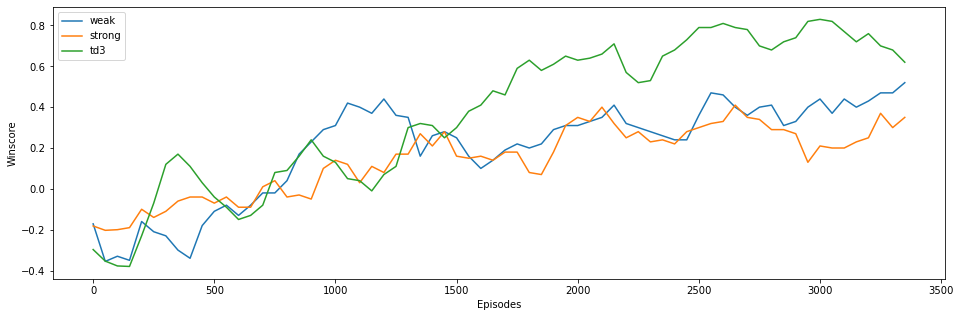

In [17]:
env.update_weights(add=True)
stats = np.array(env.weights).T
x,y = stats.shape
plt.figure(figsize=(16,5))
for i,agent,name in zip(stats,env.agents,['weak','strong','td3']):
    plt.plot(np.arange(y-1)*50,i[1:],label=name)
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Winscore')
plt.savefig('TD3/Plots/super.svg')
plt.show()

In [18]:
env.close()